# 🌸 PyTorch를 활용한 데이터 증강 및 이미지 분류

TensorFlow 튜토리얼에서 사용한 데이터 증강 및 이미지 분류 예제를 **PyTorch**와 **torchvision**을 사용하여 재현한 코드 예제입니다.  
이 예제에서는 **꽃 이미지 데이터셋**(예: `ImageFolder` 형식으로 구성된 데이터셋)을 대상으로 진행됩니다.

## 📝 진행 순서

1. **데이터 전처리**  
   - 크기 조정  
   - 스케일링  

2. **데이터 증강**  
   - 랜덤 **좌우/상하 반전**  
   - **회전** 등  

3. **사용자 정의 증강**  
   - 예: **색상 반전**  

4. **간단한 CNN 모델 구성 및 훈련**  

In [21]:
import os
import random
import tensorflow as tf  # 이미지 다운로드에 사용
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

## 1. 이미지 데이터셋 다운로드 (Keras 사용)

Keras의 `tf.keras.utils.get_file`을 사용해 flower_photos 데이터셋을 다운로드하고 압축을 풉니다.

In [22]:
# 다운로드 URL: flower_photos 데이터셋 (텐서플로우 튜토리얼에서 사용하는 데이터셋)
data_dir = tf.keras.utils.get_file(
    'flower_photos', 
    'http://download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

# tf.keras.utils.get_file()은 압축 해제 후 데이터셋 경로(문자열)를 반환합니다.
# 다운로드된 데이터는 보통 '{cache_dir}/datasets/flower_photos' 경로에 위치합니다.
print("Data directory:", data_dir)

Data directory: C:\Users\user\.keras\datasets\flower_photos


## 2. 데이터 전처리 및 증강 (PyTorch)
PyTorch의 `torchvision.transforms`를 사용하여 데이터 증강 및 전처리를 구성합니다.
여기서는 훈련 시에는 무작위 좌/우, 상/하 뒤집기와 20도 내외 회전, 그리고 이미지 크기 조정을 수행합니다.
검증/테스트에서는 크기 조정과 텐서 변환만 수행합니다.


In [23]:
IMG_SIZE = 180  # 이미지 크기

# 훈련 데이터에 적용할 변환: 크기 조정, 무작위 뒤집기/회전, 텐서 변환, (필요시) 정규화
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),  # [0,1] 범위로 변환
    # 예: 정규화가 필요하면 아래와 같이 추가할 수 있음
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),
])

# 검증/테스트용 변환: 크기 조정과 텐서 변환만 수행
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

### 사용자 정의 데이터 증강 (예: 무작위 색상 반전)

아래는 확률 `p`로 이미지를 반전시키는 커스텀 transform 예제입니다.
(torchvision 0.13 이상에서는 transforms.functional.invert()가 지원됩니다.)

In [ ]:
class RandomInvert(object):
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img):
        # img는 PIL 이미지입니다.
        if random.random() < self.p:
            # torchvision.transforms.functional.invert 는 torchvision 0.13 이상에서 사용 가능
            return transforms.functional.invert(img)
        return img

In [26]:
# 예시로 train_transforms에 추가해보려면:
train_transforms_with_invert = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    RandomInvert(p=0.3),  # 30% 확률로 색상 반전
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

## 3. 데이터셋 준비 및 분할

다운로드한 데이터셋은 디렉토리 구조가 **클래스별 폴더** 형식이므로 `ImageFolder`로 불러올 수 있습니다.
여기서는 전체 데이터셋을 80%(훈련), 10%(검증), 10%(테스트)로 분할합니다.

In [27]:
# ImageFolder를 이용하여 전체 데이터셋 로드
dataset = ImageFolder(root=data_dir, transform=train_transforms)
print("전체 이미지 개수:", len(dataset))
print("클래스:", dataset.classes)

# 데이터 분할 (80% train, 10% val, 10% test)
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# 검증/테스트 데이터셋에는 transform을 새로 적용 (정규화만 포함)
# ImageFolder에서는 transform은 객체 생성 시 고정되므로, val/test에는 새 ImageFolder 객체를 만드는 방법도 있음.
# 여기서는 간단하게 transform 변경을 위해 dataset.dataset.transform 속성을 수정합니다.
val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

전체 이미지 개수: 3670
클래스: ['flower_photos']
Train: 2936, Val: 367, Test: 367


## 4. DataLoader 구성

In [28]:
batch_size = 32
num_workers = 4  # 시스템에 맞게 조절

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## 5. 간단한 CNN 모델 정의 (PyTorch)

TensorFlow 예제와 유사하게 3개의 컨볼루션 블록과 2개의 완전 연결 층을 갖는 모델을 구성합니다.

In [29]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # 입력 채널 3, 출력 16
            nn.ReLU(),
            nn.MaxPool2d(2),  # 크기 절반 감소

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 세 개의 풀링 레이어를 거치면 이미지 크기는 IMG_SIZE/8 x IMG_SIZE/8 가 됨.
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes).to(device)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=30976, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


## 6. 손실함수와 옵티마이저 설정

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 7. 모델 훈련

In [31]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 초기화
        optimizer.zero_grad()
        
        # 순전파
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    
    # 검증 단계
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            
    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)
    print(f"Validation - Loss: {val_loss:.4f} Acc: {val_acc:.4f}")


Epoch 1/5 - Loss: 0.0000 Acc: 1.0000
Validation - Loss: 0.0000 Acc: 1.0000
Epoch 2/5 - Loss: 0.0000 Acc: 1.0000
Validation - Loss: 0.0000 Acc: 1.0000
Epoch 3/5 - Loss: 0.0000 Acc: 1.0000
Validation - Loss: 0.0000 Acc: 1.0000
Epoch 4/5 - Loss: 0.0000 Acc: 1.0000
Validation - Loss: 0.0000 Acc: 1.0000
Epoch 5/5 - Loss: 0.0000 Acc: 1.0000
Validation - Loss: 0.0000 Acc: 1.0000


## 9. 데이터 증강 결과 시각화 (옵션)

몇 가지 증강된 이미지를 시각화하여 결과를 확인해볼 수 있습니다.
아래는 훈련용 변환(train_transforms)을 적용한 예시입니다.

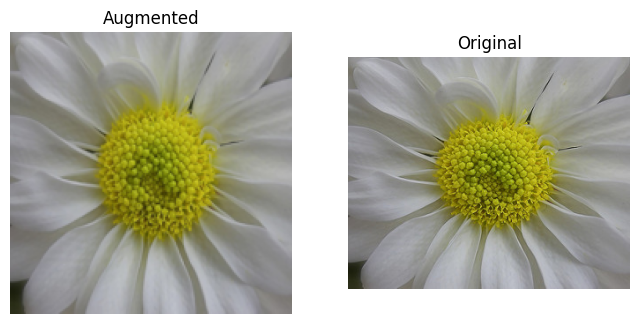

In [32]:
def imshow(img_tensor, title=None):
    # img_tensor: C x H x W 텐서 -> H x W x C
    img = img_tensor.permute(1, 2, 0).numpy()
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis("off")

# 임의의 이미지를 선택하여 증강 결과 확인
sample_img, sample_label = dataset[0]
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
imshow(sample_img, title="Augmented")
# 원본 이미지를 보려면, transform 적용 전 원본 파일을 PIL 이미지로 열어봅니다.
from PIL import Image
orig_img = Image.open(dataset.samples[0][0])
plt.subplot(1, 2, 2)
plt.imshow(orig_img)
plt.title("Original")
plt.axis("off")
plt.show()